In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
data = pd.read_excel('공모전_제공_데이터(1차).xlsx', sheet_name = '학습데이터')

In [3]:
data = data.rename(columns={'최종분류(우선순위 가장 높은것 선택)':'최종분류'})

In [4]:
label = []
for i in range(0, len(data)):
    if data['최종분류'][i][0:2] == '불만':
        label.append(-1)
    elif data['최종분류'][i][0:2] == '중립':
        label.append(0)
    elif data['최종분류'][i][0:2] == '칭찬':
        label.append(1)

In [6]:
data['label'] = label

In [7]:
contents = []
labels = []
for i in range(50,950):
    contents.append(data['발화'][i])
    labels.append(data['label'][i])

In [8]:
train_data = pd.DataFrame({"content":contents, "label":labels})

In [9]:
contents = []
labels = []
for i in range(0,50):
    contents.append(data['발화'][i])
    labels.append(data['label'][i])
for i in range(950,1000):
    contents.append(data['발화'][i])
    labels.append(data['label'][i])

In [10]:
test_data = pd.DataFrame({"content":contents, "label":labels})

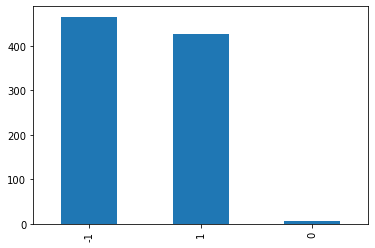

In [11]:
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0     -1    466
1      0      7
2      1    427


In [13]:
print(train_data.isnull().values.any())

False


In [14]:
print(len(train_data))

900


In [15]:
train_data.head(5)

,content,label
0,상담원 연결대기 시간이 길지않으면 합니다,-1
1,상담원 통화 대기시간이 너무길다,-1
2,상담원과 통화하 대기시간이 너무길어요,-1
3,상담원과의 통화 대기시간이 짧앗으면 좋겟음ᆢ,-1
4,상담원과의 통화대기시간이 너무길다,-1


# 전처리

In [17]:
train_data['content'] = train_data['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,content,label
0,상담원 연결대기 시간이 길지않으면 합니다,-1
1,상담원 통화 대기시간이 너무길다,-1
2,상담원과 통화하 대기시간이 너무길어요,-1
3,상담원과의 통화 대기시간이 짧앗으면 좋겟음,-1
4,상담원과의 통화대기시간이 너무길다,-1


In [18]:
train_data['content'] = train_data['content'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['content'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

content    0
label      0
dtype: int64


In [19]:
test_data.drop_duplicates(subset = ['content'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['content'] = test_data['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['content'] = test_data['content'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['content'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 100


# 토큰화

### 불용어(한국어에서는 조사나 접속사 같은 것)을 제외하고, 한글의 기본단위 형태로 문장을 분할하는 것

### 형태소 분석기를 통해 형태소로 분할한다.

### 토큰화 라이브러리는 다양하게 존재하며 형태소 뿐만 아니라 단어와 품사가 매핑된 형태로도 토큰화 과정을 할 수 있다.

In [20]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [21]:
okt = Okt()

In [22]:
# morphs : 형태소로 분할하는 함수
okt.morphs('오늘 너무 더워서 죽을 것 같다.', stem = True)

['오늘', '너무', '덥다', '죽', '을', '것', '같다', '.']

In [44]:
X_train = []
for sentence in train_data['content']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [45]:
print(X_train[:3])

[['상담', '원', '연결', '대기', '시간', '길다', '않다'], ['상담', '원', '통화', '대', '기', '시간', '너무', '길다'], ['상담', '원', '통화', '하', '대', '기', '시간', '너무', '기다']]


In [46]:
X_test = []
for sentence in test_data['content']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [48]:
print(tokenizer.word_index)

{'상담': 1, '친절하다': 2, '감사하다': 3, '너무': 4, '해주다': 5, '을': 6, '좋다': 7, '원': 8, '연결': 9, '통화': 10, '시간': 11, '감사': 12, '화면': 13, '친절': 14, '카드': 15, '되다': 16, '고객': 17, '직원': 18, '드리다': 19, '있다': 20, '상담사': 21, '대기': 22, '전화': 23, '불편하다': 24, '연': 25, '없다': 26, '설명': 27, '로': 28, '회비': 29, '정확하다': 30, '받다': 31, '터치': 32, '되어다': 33, '때': 34, '보이다': 35, '않다': 36, '까지': 37, '안내': 38, '응대': 39, '답변': 40, '바로': 41, '더': 42, '길다': 43, '처리': 44, '내용': 45, '서비스': 46, '같다': 47, '많다': 48, '다른': 49, '요': 50, '에서': 51, '시': 52, '다': 53, '기분': 54, '회사': 55, '빠르다': 56, '삼성': 57, '적': 58, '많이': 59, '아니다': 60, '보다': 61, '말투': 62, '것': 63, '비싸다': 64, '하': 65, '기다': 66, '매우': 67, '타': 68, '성': 69, '질문': 70, '문의': 71, '모르다': 72, '무': 73, '이자': 74, '만': 75, '넘다': 76, '어렵다': 77, '하고': 78, '주다': 79, '음성': 80, '대': 81, '기': 82, '사': 83, '삼': 84, '면': 85, '할부': 86, '과의': 87, '함': 88, '자다': 89, '분': 90, '디지털': 91, '힘들다': 92, '말': 93, '알다': 94, '선택': 95, '짧다': 96, '빨리': 97, '좀더': 98, '못': 99, '생각': 100, '오늘': 101, 

In [49]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 1198
등장 빈도가 1번 이하인 희귀 단어의 수: 656
단어 집합에서 희귀 단어의 비율: 54.757929883138566
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.741609741609741


In [50]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 543


In [51]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [52]:
print(X_train[:3])

[[1, 8, 9, 22, 11, 43, 36], [1, 8, 10, 81, 82, 11, 4, 43], [1, 8, 10, 65, 81, 82, 11, 4, 66]]


In [53]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [54]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [55]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

900
900


C:\Users\muyng\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 57
리뷰의 평균 길이 : 6.753333333333333


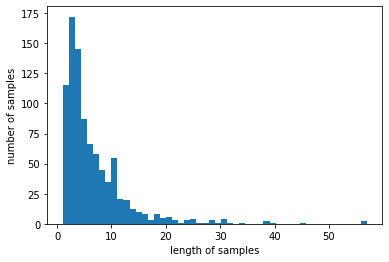

In [56]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [57]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [58]:
max_len = 20
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 96.11111111111111


In [59]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [60]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [70]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split = 0.1)

Epoch 1/10
81/81 [==============================] - 5s 21ms/step - loss: 0.0000e+00 - accuracy: 0.0044 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
81/81 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 0.0070 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
81/81 [==============================] - 1s 17ms/step - loss: 0.0000e+00 - accuracy: 0.0117 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
81/81 [==============================] - 1s 13ms/step - loss: 0.0000e+00 - accuracy: 0.0043 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/10
81/81 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 0.0068 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/10
81/81 [==============================] - 1s 13ms/step - loss: 0.0000e+00 - accuracy: 0.0051 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/10
81/81 [==============================] - 1s 12ms/step - loss: 0.0000e+0

In [62]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [68]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=`0, validation_split=0.1)

Epoch 1/15
14/14 [==============================] - 4s 76ms/step - loss: -3.3243 - acc: 0.0051 - val_loss: 19.7427 - val_acc: 0.0000e+00

Epoch 00001: val_acc did not improve from 0.00000
Epoch 2/15
14/14 [==============================] - 0s 22ms/step - loss: -6.3491 - acc: 0.0101 - val_loss: 17.1504 - val_acc: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.00000
Epoch 3/15
14/14 [==============================] - 0s 21ms/step - loss: -8.3393 - acc: 0.0118 - val_loss: 18.8208 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.00000
Epoch 4/15
14/14 [==============================] - 0s 22ms/step - loss: -11.9964 - acc: 0.0231 - val_loss: 23.7881 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve from 0.00000
Epoch 5/15
14/14 [==============================] - 0s 23ms/step - loss: -12.6344 - acc: 0.1293 - val_loss: 21.1669 - val_acc: 0.0000e+00

Epoch 00005: val_acc did not improve from 0.00000
Epoch 6/15
14/14 [==============================] - 1s 44m

In [64]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

4/4 [==============================] - 1s 6ms/step - loss: -0.0138 - acc: 0.0000e+00

 테스트 정확도: 0.0000


In [65]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [66]:
sentiment_predict('상담을 너무 잘해줘요')

100.00% 확률로 부정 리뷰입니다.



In [75]:
sentiment_predict('상담이 별로예요')

100.00% 확률로 부정 리뷰입니다.



In [76]:
sentiment_predict('친절하지만 설명을 잘 못한거 같아요')

100.00% 확률로 부정 리뷰입니다.



In [73]:
y_train

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1